# NER CRF - Atos de Contratos

## Configurando o ambiente

Se estiver utilizanod o VSCode na sua máquina local ou no servidor do projeto, o primeio passo é criar o ambiente virtual.

* Acesse a pasta onde vai colocar o seu projeto, no meu caso está em:

        /home/lucelia_vieira/Experimentos


* Crie o ambiente
    
        python3 -m venv 
    

* Para ativar o ambiente virtual localmente:
    
        source /home/lucelia_vieira/Experimentos/venv/bin/activate


A primeira vez que carregar o projeto no VScode execute:

#!virtualenv --python=python3.8 venv

Instale os pacotes abaixo direto no ambiente criado caso não queira ter que executar essa célula sempre que tiver que executar o projeto.

Para instalar direto no ambiente, o ambiente precisa estar ativo, conforme instrução para ativar o ambiente.

Se estiver utilizanodo o Collab, alguns desses pacotes já estarão disponíveis, outros não. Então, na dúvida, execute sempre...

In [47]:
#!pip3 install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
#!pip install seqeval
#!pip install scikit-learn==0.24
#!pip install sklearn==0.0
#!pip install sklearn-crfsuite==0.3.6
#!pip install python-crfsuite==0.9.7
#!pip install tqdm
#!pip install pytorch-crf==0.7.2
#!pip install torch==1.8.1
#!pip install torch==1.11.0
#!pip install torch-summary
#!pip install nltk-3.7
#!pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
#!pip install matplotlib-3.5.2
#!pip install tensorflow

Imports dos pacotes que serão utilizados no código

In [48]:
import pandas as pd
import nltk
import scipy.stats
import sklearn
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics
import matplotlib.pyplot as plt
%matplotlib inline
nltk.download('punkt')
import numpy as np


[nltk_data] Downloading package punkt to
[nltk_data]     /home/lucelia_vieira/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Converte CSV para Padrão IOB

Ao carregar o csv pelo pandas especifique o data class das colunas. No nosso caso todas são String, então:

     dtype=str

In [49]:
data = pd.read_csv('/home/lucelia_vieira/Experimentos/ner/CSVs/DODFCorpus_contratos_licitacoes_v0.csv', dtype=str)

In [50]:
len(data)

30382

Para o iob_transformer fazer a correlação ato-entidades_correspondentes é necessário ter uma coluna id_ato, que junte o id do dodf e o id da relação específica.

Mas para que funcione corretamente as colunas id_dodf e id_rel devem ser do tipo String, conforme abaixo: 

 1   id_dodf       30382 non-null  object
 
 3   id_rel        30382 non-null  object

In [51]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30382 entries, 0 to 30381
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0    30382 non-null  object
 1   id_dodf       30382 non-null  object
 2   tipo_rel      30382 non-null  object
 3   id_rel        30382 non-null  object
 4   anotador_rel  30382 non-null  object
 5   tipo_ent      30382 non-null  object
 6   id_ent        30382 non-null  object
 7   anotador_ent  30382 non-null  object
 8   offset        30382 non-null  object
 9   length        30382 non-null  object
 10  texto         30382 non-null  object
 11  id_ato        30382 non-null  object
dtypes: object(12)
memory usage: 2.8+ MB


In [52]:
data['id_ato'] = data['id_dodf'] + '-' + data['id_rel']
data

Unnamed: 0     id_dodf                 tipo_rel id_rel  \
0              0  7_2.8.2019  REL_ADITAMENTO_CONTRATO    R11   
1              1  7_2.8.2019  REL_ADITAMENTO_CONTRATO    R11   
2              2  7_2.8.2019  REL_ADITAMENTO_CONTRATO    R11   
3              3  7_2.8.2019  REL_ADITAMENTO_CONTRATO    R11   
4              4  7_2.8.2019  REL_ADITAMENTO_CONTRATO    R11   
...          ...         ...                      ...    ...   
30377      30394         631  REL_ADITAMENTO_CONTRATO   R157   
30378      30395         631  REL_ADITAMENTO_CONTRATO   R157   
30379      30396         631  REL_ADITAMENTO_CONTRATO   R157   
30380      30397         631  REL_ADITAMENTO_CONTRATO   R157   
30381      30398         631  REL_ADITAMENTO_CONTRATO   R157   

           anotador_rel                       tipo_ent id_ent  \
0      anotador_4624608           numero_termo_aditivo    140   
1      anotador_4624608                numero_contrato    141   
2      anotador_4624608                numero_contrato    142   
3      anotador_4624608                   processo_gdf    139   
4      anotador_4624608              orgao_contratante    143   
...                 ...                            ...    ...   
30377  anotador_4624608              orgao_contratante   2050   
30378  anotador_4624608   objeto_aditamento_contratual   2186   
30379  anotador_4624608                   processo_gdf   2052   
30380  anotador_4624608                   data_escrito   2185   
30381  anotador_4624608  EXTRATO_ADITAMENTO_CONTRATUAL   2235   

           anotador_ent  offset length  \
0      anotador_4624608  372177      6   
1      anotador_4624608  372213      8   
2      anotador_4624608  372231      6   
3      anotador_4624608  372260     19   
4      anotador_4624608  372294     82   
...                 ...     ...    ...   
30377  anotador_4624608  281629     38   
30378  anotador_4624608  281779    477   
30379  anotador_4624608  282273     10   
30380  anotador_4624608  283587     10   
30381  anotador_4624608  281565   2456   

                                                   texto          id_ato  
0                                                 QUARTO  7_2.8.2019-R11  
1                                               002/2019  7_2.8.2019-R11  
2                                                 033411  7_2.8.2019-R11  
3                                    00361-0 000853/2016  7_2.8.2019-R11  
4      SECRETARIA DE ESTADO DE\nPROTECAO DA ORDEM URB...  7_2.8.2019-R11  
...                                                  ...             ...  
30377             Tribunal de Contas do Distrito Federal        631-R157  
30378  prestação dos serviços de locação de veículos,...        631-R157  
30379                                         20065/2016        631-R157  
30380                                         23/12/2021        631-R157  
30381  EXTRATO DO 6º TERMO ADITIVO AO CONTRATO Nº 28/...        631-R157  

[30382 rows x 12 columns]

Checando o tipo da coluna id_ato

In [53]:

#type(data.at[30379, 'id_ato'])

Checando o formato do id_ato

In [54]:

data.at[30377, 'id_ato']

'631-R157'

Feito isso, podemos checar o número de labels por Ato.

In [55]:
result = data.groupby('tipo_rel')['id_ato'].nunique()
print(result.sort_values(ascending=False))


tipo_rel
REL_ADITAMENTO_CONTRATO     1260
REL_EXTRATO_CONTRATO        1223
REL_AVISO_LICITACAO          317
REL_ANUL_REVOG_LICITACAO      31
REL_SUSPENSAO_LICITACAO       26
REL_EXTRATO_CONVENIO          18
Name: id_ato, dtype: int64


Com os dados certinhos, podemos fazer uso do iob_transformer normalmente, mas antes vamos relizar alguns filtros.

O primeiro filtro a ser aplicado é pelo tipo de ATO:

In [56]:
data.tipo_rel.value_counts()

REL_EXTRATO_CONTRATO        16549
REL_ADITAMENTO_CONTRATO      9626
REL_AVISO_LICITACAO          3608
REL_ANUL_REVOG_LICITACAO      236
REL_EXTRATO_CONVENIO          184
REL_SUSPENSAO_LICITACAO       179
Name: tipo_rel, dtype: int64

É utilizados uns ilocs no código do transformer, então por via das dúvidas é bom dar um reset_index nos dataframes filtrados:

In [57]:
tipo_ato = data.loc[data['tipo_rel'] == 'REL_EXTRATO_CONTRATO'].reset_index(drop=True)
#tipo_ato.to_csv("/home/lucelia_vieira/Experimentos/ner/CSVs/REL_EXTRATO_CONTRATO_COMPLETO.csv")
tipo_ato


Unnamed: 0     id_dodf              tipo_rel id_rel       anotador_rel  \
0             27  7_2.8.2019  REL_EXTRATO_CONTRATO     R1  anotador_57452550   
1             28  7_2.8.2019  REL_EXTRATO_CONTRATO     R1  anotador_57452550   
2             29  7_2.8.2019  REL_EXTRATO_CONTRATO     R1  anotador_57452550   
3             30  7_2.8.2019  REL_EXTRATO_CONTRATO     R1  anotador_57452550   
4             31  7_2.8.2019  REL_EXTRATO_CONTRATO     R1  anotador_57452550   
...          ...         ...                   ...    ...                ...   
16544      30386         631  REL_EXTRATO_CONTRATO   R100  anotador_29845489   
16545      30387         631  REL_EXTRATO_CONTRATO   R100  anotador_29845489   
16546      30388         631  REL_EXTRATO_CONTRATO   R100  anotador_29845489   
16547      30389         631  REL_EXTRATO_CONTRATO   R100  anotador_29845489   
16548      30390         631  REL_EXTRATO_CONTRATO   R100  anotador_29845489   

                       tipo_ent id_ent       anotador_ent  offset length  \
0               numero_contrato     68  anotador_57452550  384816      7   
1             orgao_contratante     69  anotador_57452550  384843     56   
2           entidade_contratada     70  anotador_57452550  384904     81   
3                  processo_gdf     67  anotador_57452550  384997     24   
4               objeto_contrato     71  anotador_57452550  385031    221   
...                         ...    ...                ...     ...    ...   
16544           objeto_contrato   1323  anotador_29845489  280315    456   
16545         programa_trabalho   1325  anotador_29845489  280825     21   
16546              nota_empenho   1327  anotador_29845489  280921     11   
16547            valor_contrato   1329  anotador_29845489  281121     12   
16548  data_assinatura_contrato   1331  anotador_29845489  281272     10   

                                                   texto         id_ato  
0                                                01/2019  7_2.8.2019-R1  
1      Companhia de\nPlanejamento do Distrito Federal...  7_2.8.2019-R1  
2      Servico Social da Industria - Departamento Reg...  7_2.8.2019-R1  
3                               00121.00000.0897/2019-41  7_2.8.2019-R1  
4      Patrocinio do Concurso V\nPREMIO CODEPLAN DE T...  7_2.8.2019-R1  
...                                                  ...            ...  
16544  locação de máquinas e equipamentos destinados ...       631-R100  
16545                              11.333.6207.2900.0017       631-R100  
16546                                        2021NE00659       631-R100  
16547                                       1.215.840,00       631-R100  
16548                                         20/12/2021       631-R100  

[16549 rows x 12 columns]

In [58]:
#apenas para rodar o iob com spacy
#csv_reader = pd.read_csv("/home/lucelia_vieira/Experimentos/ner/CSVs/REL_EXTRATO_CONTRATO_COMPLETO.csv", nrows=2000)

In [59]:
tipo_ato.tipo_ent.value_counts()

orgao_contratante           1715
numero_contrato             1386
entidade_contratada         1249
processo_gdf                1234
EXTRATO_CONTRATO            1223
objeto_contrato             1217
vigencia_contrato           1185
valor_contrato              1113
fonte_recurso               1060
programa_trabalho           1024
nota_empenho                1017
data_assinatura_contrato     881
natureza_despesa             875
unidade_orcamentaria         807
cnpj_entidade_contratada     339
nome_responsavel             132
cnpj_orgao_contratante        88
codigo_siggo                   4
Name: tipo_ent, dtype: int64

In [60]:
""" # CODIGO RESPONSAVEL PELA LIMPEZA DO TEXTO DA BASE OURO
tipo_ato_2 = tipo_ato.copy()
#tipo_ato_2 = csv_reader.copy()
tipo_ato_2.texto = tipo_ato_2.texto.str.replace("\n", " ")
tipo_ato_2.texto = tipo_ato_2.texto.str.replace("  ", " ") """

' # CODIGO RESPONSAVEL PELA LIMPEZA DO TEXTO DA BASE OURO\ntipo_ato_2 = tipo_ato.copy()\n#tipo_ato_2 = csv_reader.copy()\ntipo_ato_2.texto = tipo_ato_2.texto.str.replace("\n", " ")\ntipo_ato_2.texto = tipo_ato_2.texto.str.replace("  ", " ") '

Alguns atos possuem entidades rotuladas incorretamente, ou que, a quantide de rótulos não seja representativo. Nesse caso, sugere-se remover essas entidades do dataset.

In [61]:
#l = ['codigo_siggo','numero_convenio','nome_responsavel']
#l = ['codigo_siggo','numero_convenio','nome_responsavel']

#tipo_ato = tipo_ato.loc[~tipo_ato.tipo_ent.isin(l)]

In [62]:
teste = tipo_ato.loc[tipo_ato['id_ato'] == "7_2.8.2019-R11"].reset_index(drop=True)

Após ter aplicado todos os filtros no dataset, podemos realizar o transfomer e converter para o formato IOB.

In [63]:
# return_df=False para retornar atos e labels, ou  return_df=True para retornar dataset
from iob_transformer import iob_transformer
iob = iob_transformer('id_ato','texto','tipo_ent', keep_punctuation=False, return_df=False)

In [64]:
atos, labels = iob.transform(tipo_ato)

Para conferir se o foi realizado corretamente o iob ao dataset, imprima o retorno do transformer em formato de dataset:

In [65]:
iob_dataset = iob_transformer('id_ato', 'texto',
                      'tipo_ent', keep_punctuation=True, return_df=True)

In [66]:
#dataset_iob = iob_dataset.transform(tipo_ato)
#dataset_iob

In [67]:
atos

[['EXTRATOS',
  'DE',
  'CONTRATOS',
  'EXTRATO',
  'DO',
  'CONTRATO',
  'DE',
  'PATROCINIO',
  'No',
  '01/2019',
  ',',
  'celebrado',
  'entre',
  'a',
  'Companhia',
  'de',
  'Planejamento',
  'do',
  'Distrito',
  'Federal',
  '-',
  'CODEPLAN',
  'e',
  'o',
  'Servico',
  'Social',
  'da',
  'Industria',
  '-',
  'Departamento',
  'Regional',
  'do',
  'Distrito',
  'Federal',
  '-',
  'SESI',
  '/',
  'DF',
  '.',
  'Processo',
  ':',
  '00121.00000.0897/',
  '2019-41',
  '.',
  'Objeto',
  ':',
  'Patrocinio',
  'do',
  'Concurso',
  'V',
  'PREMIO',
  'CODEPLAN',
  'DE',
  'TRABALHOS',
  'TECNICO-CIENTIFICOS',
  ',',
  'acerca',
  'do',
  'Desenvolvimento',
  'do',
  'Distrito',
  'Federal',
  'e',
  'Regiao',
  'Integrada',
  'de',
  'Desenvolvimento',
  'do',
  'Distrito',
  'Federal',
  'e',
  'Entorno-RIDE',
  ',',
  'conforme',
  'Plano',
  'de',
  'Trabalho',
  '.',
  'Vigencia',
  ':',
  'O',
  'presente',
  'Contrato',
  'tera',
  'vigencia',
  'de',
  '06',
  '(',

In [68]:
#Cria uma Lista 
atos_list = []
for i in atos:
   if not isinstance(i, list):
      atos_list.append(i)
   else:
      for j in i:
        atos_list.append(j)

len(atos_list)

293638

In [69]:
df = pd.DataFrame(atos_list,columns=['Texto']) 
df.to_csv('./CSVs/atos.csv')

In [70]:
#Cria uma Lista 
label_list = []
for i in labels:
   if not isinstance(i, list):
      label_list.append(i)
   else:
      for j in i:
        label_list.append(j)

len(label_list)

293638

Listando as tags após a conversão para IOB

In [71]:
tags = set()

for label in labels:
    for tag in label:
        tags.add(tag)
tags = list(tags)
num_tags = len(tags)

In [72]:
tags

['B-valor_contrato',
 'I-unidade_orcamentaria',
 'B-entidade_contratada',
 'I-vigencia_contrato',
 'I-numero_contrato',
 'I-valor_contrato',
 'B-cnpj_entidade_contratada',
 'B-vigencia_contrato',
 'B-codigo_siggo',
 'B-processo_gdf',
 'B-programa_trabalho',
 'I-data_assinatura_contrato',
 'I-objeto_contrato',
 'B-fonte_recurso',
 'I-nota_empenho',
 'I-fonte_recurso',
 'B-unidade_orcamentaria',
 'B-orgao_contratante',
 'I-orgao_contratante',
 'I-processo_gdf',
 'B-objeto_contrato',
 'B-data_assinatura_contrato',
 'I-cnpj_entidade_contratada',
 'I-codigo_siggo',
 'B-cnpj_orgao_contratante',
 'B-nome_responsavel',
 'B-natureza_despesa',
 'B-numero_contrato',
 'I-programa_trabalho',
 'I-cnpj_orgao_contratante',
 'B-nota_empenho',
 'I-nome_responsavel',
 'O',
 'I-natureza_despesa',
 'I-entidade_contratada']

In [103]:
x=atos
y=labels

## Separate train and test splits (in order)

Aqui usamos trains_test_split do sklearn para separar os conjuntos de treino e teste de forma randômica e sistematizada.

In [74]:
# import numpy as np
# from sklearn.model_selection import KFold
# kf = KFold(n_splits=5)
# kf.get_n_splits(x)

# lista_split = []

# for train_index, test_index in kf.split(x):
#     print("TRAIN:", train_index, "TEST:", test_index)
#     x_train, x_test = x[train_index], x[test_index]
#     y_train, y_test = y[train_index], y[test_index]
#     lista_split.append(x_test)

# #lista_split[0]



In [104]:
from sklearn.model_selection import train_test_split
# 80% treino, 20% teste
#x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=None, shuffle=False)
#random_state: the seed number to be passed to the shuffle operation, thus making the experiment reproducible.
x_train_s, x_test_s, y_train_s, y_test_s = train_test_split(atos, labels, test_size=0.2, random_state=None, shuffle=True)
print( 'x_train',len(x_train_s),'\n','x_test',len(x_test_s),'\n','total atos',len(atos))

x_train 978 
 x_test 245 
 total atos 1223


In [76]:
x_test_s

[['EXTRATO',
  'DO',
  'CONTRATO',
  'Nº',
  '165/2021',
  'Processo',
  ':',
  '00150-00003951/',
  '2021-41',
  '.',
  'Das',
  'Partes',
  ':',
  'DF',
  '/',
  'SECEC',
  '/',
  'FAC',
  'X',
  'GIANCARLO',
  'MARTINS',
  'na',
  'qualidade',
  'de',
  'Contratado',
  '(',
  'a',
  ')',
  '.',
  'Espécie',
  ':',
  'Contrato',
  'nº',
  '165/2021',
  '.',
  'Nota',
  'de',
  'Empenho',
  ':',
  '00395/2021',
  '.',
  'Do',
  'Objeto',
  ':',
  'O',
  'presente',
  'Contrato',
  'tem',
  'por',
  'objeto',
  'a',
  'prestação',
  'de',
  'serviços',
  'de',
  'emissão',
  'de',
  'análise',
  'técnica',
  'e',
  'de',
  'mérito',
  'cultural',
  'nos',
  'projetos',
  'a',
  'que',
  'lhe',
  'forem',
  'designados',
  ';',
  'DO',
  'VALOR',
  'ESTIMADO',
  ':',
  '4.475,00',
  '(',
  'quatro',
  'mil',
  ',',
  'quatrocentos',
  'e',
  'setenta',
  'e',
  'cinco',
  'reais',
  ')',
  'que',
  'serão',
  'liberados',
  'em',
  'parcela',
  'única',
  'e',
  'transferidos',
  'à',
 

In [105]:
#Cria uma Lista com o x_test
x_test_list = []
for i in x_test_s:
   if not isinstance(i, list):
      x_test_list.append(i)
   else:
      for j in i:
        x_test_list.append(j)

len(x_test_list)

61372

In [ ]:
print(x_test_list)

['EXTRATO', 'DO', 'CONTRATO', 'Nº', '44399/2021', '\n', 'Processo', ':', '04001-0000000336/', '2021-65', '-', 'DAS', 'PARTES', ':', 'INSTITUTO', 'DE', 'ASSIST', '.', 'À', 'SAÚDE', 'DOS', 'SERV', '.', 'DO', 'DF-INAS', 'na', 'qualidade', 'de', 'CONTRATANTE', ',', 'CENTRO', 'DE', 'MEDICINA', 'NUCLEAR', 'DE', 'BRASILIA', 'LTDA', 'na', 'qualidade', 'de', 'CONTRATADA', '.', 'DO', 'OBJETO', ':', 'CREDECIAMENTO', 'DE', 'PESSOAS', 'JURIDICAS', 'PARA', 'PRESTAÇÃO', 'DE', 'SERVIÇOS', 'DE', 'SAÚDE', 'AOS', 'BENEFICIÁRIOS', 'DO', 'PLANO', 'DE', 'ASSISTÊNCIA', 'SUPLEMENTAR', 'À', 'SAÚDE', '-', 'GDF-SAÚDE-DF', ',', 'COMPREENDENDO', 'ASSISTÊNCIA', 'MÉDICA', 'E', 'SERVIÇOS', 'AUXILIARES', 'DE', 'DIAGNÓSTICO', 'E', 'TERAPIA', ';', 'CONFORME', 'CONTRATO', '.', 'DO', 'VALOR', ':', 'R$', '6.025,49', '(', 'seis', 'mil', 'e', 'vinte', 'e', 'cinco', 'reais', 'e', 'quarenta', 'e', 'nove', 'centavos', ')', 'e', 'correrá', 'à', 'conta', 'de', 'dotações', 'orçamentárias', 'consignadas', 'no', 'orçamento', 'corren

In [106]:
y_test_list = []
for i in y_test_s:
   if not isinstance(i, list):
      y_test_list.append(i)
   else:
      for j in i:
       y_test_list.append(j)

len(y_test_list)

61372

In [79]:
x_test_list

['EXTRATO',
 'DO',
 'CONTRATO',
 'Nº',
 '165/2021',
 'Processo',
 ':',
 '00150-00003951/',
 '2021-41',
 '.',
 'Das',
 'Partes',
 ':',
 'DF',
 '/',
 'SECEC',
 '/',
 'FAC',
 'X',
 'GIANCARLO',
 'MARTINS',
 'na',
 'qualidade',
 'de',
 'Contratado',
 '(',
 'a',
 ')',
 '.',
 'Espécie',
 ':',
 'Contrato',
 'nº',
 '165/2021',
 '.',
 'Nota',
 'de',
 'Empenho',
 ':',
 '00395/2021',
 '.',
 'Do',
 'Objeto',
 ':',
 'O',
 'presente',
 'Contrato',
 'tem',
 'por',
 'objeto',
 'a',
 'prestação',
 'de',
 'serviços',
 'de',
 'emissão',
 'de',
 'análise',
 'técnica',
 'e',
 'de',
 'mérito',
 'cultural',
 'nos',
 'projetos',
 'a',
 'que',
 'lhe',
 'forem',
 'designados',
 ';',
 'DO',
 'VALOR',
 'ESTIMADO',
 ':',
 '4.475,00',
 '(',
 'quatro',
 'mil',
 ',',
 'quatrocentos',
 'e',
 'setenta',
 'e',
 'cinco',
 'reais',
 ')',
 'que',
 'serão',
 'liberados',
 'em',
 'parcela',
 'única',
 'e',
 'transferidos',
 'à',
 'conta',
 'do',
 '(',
 'a',
 ')',
 'Contratado',
 '(',
 'a',
 ')',
 ',',
 'correndo',
 'a',
 'de

In [80]:
#x_test_texto =  " ".join(" ".join(l) for l in x_test_s)   
#x_test_texto =  "".join(str(l) for l in x_test_s)
x_test_texto = list(map(' '.join, x_test_s))         
#x_test_texto


In [81]:
""" # CODIGO RESPONSAVEL PELA LIMPEZA DO TEXTO DA BASE OURO
import re

df1 =[]

for i in x_test_texto:
    i = i.replace("\n", " ")
    i = re.sub('xx[a-z]{1,10}', '', i)
    #i = i.replace(r"xx[a-z]{1,10}","")
    aux = ' '.join(i.split())
    #print(aux)
    df1.append(aux) """

' # CODIGO RESPONSAVEL PELA LIMPEZA DO TEXTO DA BASE OURO\nimport re\n\ndf1 =[]\n\nfor i in x_test_texto:\n    i = i.replace("\n", " ")\n    i = re.sub(\'xx[a-z]{1,10}\', \'\', i)\n    #i = i.replace(r"xx[a-z]{1,10}","")\n    aux = \' \'.join(i.split())\n    #print(aux)\n    df1.append(aux) '

In [93]:
#x_test para rodar o supervisao fraca
df = pd.DataFrame(x_test_texto,columns=['Texto']) 
df.to_csv('/home/lucelia_vieira/Experimentos/ner/CSVs/Extrato_Contrato_Split_1_x_test_texto.csv')

In [98]:
# converting Split Test to CSV file
# labels para validação do x_test
df = pd.DataFrame(x_test_list, columns=['Texto']) 
df.to_csv('/home/lucelia_vieira/Experimentos/ner/CSVs/Extrato_Contrato_Split_1_x_test.csv')

In [101]:
with open('./CSVs/Extrato_Contrato_Split_1_x_test.txt', 'wt') as fileout:
    for item in x_test_s:
        fileout.write(str(item))

In [100]:
# converting Split Test to CSV file
# labels para validação do x_test
df = pd.DataFrame(y_test_list, columns=['Texto']) 
df.to_csv('/home/lucelia_vieira/Experimentos/ner/CSVs/Extrato_Contrato_Split_1_y_test.csv')

In [102]:
with open('./CSVs/Extrato_Contrato_Split_1_y_test.txt', 'wt') as fileout:
    for item in y_test_s:
        fileout.write(str(item))

## Create dictionary feature for each word in each sequence in x

In [85]:
#X_train

def get_features(sentence):
        """Create features for each word in act.
        Create a list of dict of words features to be used in the predictor module.
        Args:
            act (list): List of words in an act.
        Returns:
            A list with a dictionary of features for each of the words.
        """
        sent_features = []
        
        for i in range(len(sentence)):
            word_feat = {
                'word': sentence[i].lower(),
                'capital_letter': sentence[i][0].isupper(),
                'all_capital': sentence[i].isupper(),
                'isdigit': sentence[i].isdigit(),
                'word_before': sentence[i].lower() if i == 0 else sentence[i-1].lower(),
                'word_after:': sentence[i].lower() if i+1 >= len(sentence) else sentence[i+1].lower(),
                'BOS': i == 0,
                'EOS': i == len(sentence)-1
            }
            sent_features.append(word_feat)
        return sent_features
    
for i in range(len(x_train_s)):
    x_train_s[i] = get_features(x_train_s[i])

In [86]:
#X_test
def get_features(sentence):
        """Create features for each word in act.
        Create a list of dict of words features to be used in the predictor module.
        Args:
            act (list): List of words in an act.
        Returns:
            A list with a dictionary of features for each of the words.
        """
        x_test = []
        sent_features = []
        for i in range(len(sentence)):
            word_feat = {
                'word': sentence[i].lower(),
                'capital_letter': sentence[i][0].isupper(),
                'all_capital': sentence[i].isupper(),
                'isdigit': sentence[i].isdigit(),
                'word_before': sentence[i].lower() if i == 0 else sentence[i-1].lower(),
                'word_after:': sentence[i].lower() if i+1 >= len(sentence) else sentence[i+1].lower(),
                'BOS': i == 0,
                'EOS': i == len(sentence)-1
            }
            sent_features.append(word_feat)
        return sent_features
    
for i in range(len(x_test_s)):
    x_test_s[i] = get_features(x_test_s[i])

## Model CRF Trainning

In [87]:
import sklearn_crfsuite
from sklearn_crfsuite import metrics


crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=10,
    c2=0.1,
    max_iterations=100,
    #max_iterations=50,
    
    all_possible_transitions=False,
    all_possible_states=True
)

#crf.fit(x_train, y_train)

try:
    #crf.fit(x_train[:200], y_train[:200])
    crf.fit(x_train_s, y_train_s)
except AttributeError:
    pass


## Evaluation

In [88]:
classes = list(crf.classes_)
classes.remove('O')

y_pred = crf.predict(x_test_s)
metrics.flat_f1_score(y_test_s, y_pred, average='weighted', labels=classes)

/home/lucelia_vieira/Experimentos/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1492: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(


0.8868394796573275

In [89]:
crf.classes_

['O',
 'B-numero_contrato',
 'B-processo_gdf',
 'I-processo_gdf',
 'B-orgao_contratante',
 'B-entidade_contratada',
 'I-entidade_contratada',
 'B-objeto_contrato',
 'I-objeto_contrato',
 'B-valor_contrato',
 'B-data_assinatura_contrato',
 'I-orgao_contratante',
 'B-unidade_orcamentaria',
 'B-programa_trabalho',
 'B-natureza_despesa',
 'B-fonte_recurso',
 'B-nota_empenho',
 'B-vigencia_contrato',
 'I-vigencia_contrato',
 'B-cnpj_entidade_contratada',
 'I-cnpj_entidade_contratada',
 'I-unidade_orcamentaria',
 'B-cnpj_orgao_contratante',
 'I-cnpj_orgao_contratante',
 'I-data_assinatura_contrato',
 'B-nome_responsavel',
 'I-nome_responsavel',
 'I-numero_contrato',
 'I-natureza_despesa',
 'I-programa_trabalho',
 'I-fonte_recurso',
 'B-codigo_siggo',
 'I-codigo_siggo',
 'I-nota_empenho',
 'I-valor_contrato']

In [90]:
report = metrics.flat_classification_report(
    #y_test[:200], y_pred[:200], labels=classes, digits=3))
    y_test_s, y_pred, labels=classes, digits=3, output_dict=True)
print(report)
np.save("./Results/METRICA_EXTRATO_CONTRATO_4.npy", report)


/home/lucelia_vieira/Experimentos/venv/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=['B-numero_contrato', 'B-processo_gdf', 'I-processo_gdf', 'B-orgao_contratante', 'B-entidade_contratada', 'I-entidade_contratada', 'B-objeto_contrato', 'I-objeto_contrato', 'B-valor_contrato', 'B-data_assinatura_contrato', 'I-orgao_contratante', 'B-unidade_orcamentaria', 'B-programa_trabalho', 'B-natureza_despesa', 'B-fonte_recurso', 'B-nota_empenho', 'B-vigencia_contrato', 'I-vigencia_contrato', 'B-cnpj_entidade_contratada', 'I-cnpj_entidade_contratada', 'I-unidade_orcamentaria', 'B-cnpj_orgao_contratante', 'I-cnpj_orgao_contratante', 'I-data_assinatura_contrato', 'B-nome_responsavel', 'I-nome_responsavel', 'I-numero_contrato', 'I-natureza_despesa', 'I-programa_trabalho', 'I-fonte_recurso', 'B-codigo_siggo', 'I-codigo_siggo', 'I-nota_empenho', 'I-valor_contrato'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will res

{'B-numero_contrato': {'precision': 0.9019607843137255, 'recall': 0.6548042704626335, 'f1-score': 0.7587628865979381, 'support': 281}, 'B-processo_gdf': {'precision': 0.8808510638297873, 'recall': 0.8734177215189873, 'f1-score': 0.8771186440677966, 'support': 237}, 'I-processo_gdf': {'precision': 0.88, 'recall': 0.9705882352941176, 'f1-score': 0.9230769230769231, 'support': 204}, 'B-orgao_contratante': {'precision': 0.8867313915857605, 'recall': 0.7718309859154929, 'f1-score': 0.825301204819277, 'support': 355}, 'B-entidade_contratada': {'precision': 0.8878048780487805, 'recall': 0.728, 'f1-score': 0.7999999999999999, 'support': 250}, 'I-entidade_contratada': {'precision': 0.8207282913165266, 'recall': 0.7650130548302873, 'f1-score': 0.7918918918918919, 'support': 1149}, 'B-objeto_contrato': {'precision': 0.9627906976744186, 'recall': 0.8697478991596639, 'f1-score': 0.9139072847682119, 'support': 238}, 'I-objeto_contrato': {'precision': 0.8966003316749586, 'recall': 0.932074821136109, 

/home/lucelia_vieira/Experimentos/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/lucelia_vieira/Experimentos/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [91]:
len(y_pred)

245

In [92]:
y_test_list = []
for i in y_test:
   if not isinstance(i, list):
      y_test_list.append(i)
   else:
      for j in i:
        y_test_list.append(j)

len(y_test_list)

NameError: name 'y_test' is not defined

In [ ]:
y_pred_list = []
for i in y_pred:
   if not isinstance(i, list):
      y_pred_list.append(i)
   else:
      for j in i:
        y_pred_list.append(j)

len(y_pred_list)

58759

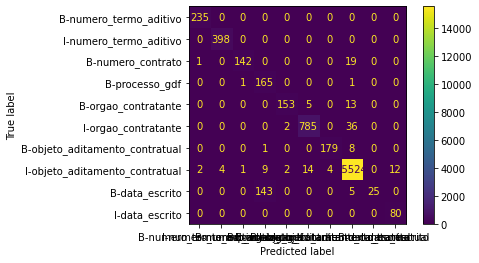

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import plot_confusion_matrix
##confusion_matrix(y_test, y_pred, labels=classes)
#classes = list(crf.classes_)
#classes.remove('I-numero_contrato')
#classes.remove('I-processo_gdf')
#classes.remove('B-11')    
classes.remove('B-12')
#classes.remove('I-valor_estimado_contratacao')
cm = confusion_matrix(y_test_list, y_pred_list, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot() 


In [ ]:
print(f'{classes}')

None


## Hyperparameter Optimization

In [ ]:
# define fixed parameters and parameters to search
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    max_iterations=100,
    all_possible_transitions=True,
    all_possible_states=True
)
params_space = {
    'c1': scipy.stats.expon(scale=15.0),
    'c2': scipy.stats.expon(scale=1.0),
}


# use the same metric for evaluation
f1_scorer = make_scorer(metrics.flat_f1_score,
                        average='weighted', labels=classes)

# search
rs = RandomizedSearchCV(crf, params_space,
                        cv=3,
                        verbose=1,
                        n_jobs=-1,
                        n_iter=50,
                        scoring=f1_scorer)
rs.fit(x_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


/home/lucelia_vieira/Experimentos/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1492: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(
/home/lucelia_vieira/Experimentos/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1492: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(
/home/lucelia_vieira/Experimentos/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1492: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(
/home/lucelia_vieira/Experimentos/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1492: UndefinedMetricWarn

RandomizedSearchCV(cv=3,
                   estimator=CRF(algorithm='lbfgs', all_possible_states=True,
                                 all_possible_transitions=True,
                                 max_iterations=100),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'c1': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f94c402f1f0>,
                                        'c2': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f94c22621c0>},
                   scoring=make_scorer(flat_f1_sco...eto_contrato', 'I-numero_convenio', 'B-cnpj_entidade_convenente', 'B-vigencia_contrato', 'I-vigencia_contrato', 'B-valor_convenio', 'B-unidade_orcamentaria', 'B-programa_trabalho', 'B-natureza_despesa', 'B-fonte_recurso', 'B-cnpj_orgao_concedente', 'B-data_assinatura_contrato', 'I-data_assinatura_convenio', 'I-unidade_orcamentaria', 'B-nota_empenho']),
                   verbose=1)

In [ ]:
print('best params:', rs.best_params_)
print('best CV score:', rs.best_score_)
print('model size: {:0.2f}M'.format(rs.best_estimator_.size_ / 1000000))

best params: {'c1': 1.6608103444597717, 'c2': 0.1444627787858007}
best CV score: 0.22201714397578617
model size: 0.02M


## Check best estimator on our test data

In [ ]:
sorted_classes = sorted(
    classes,
    key=lambda name: (name[1:], name[0])
)

classes = list(crf.classes_)
classes.remove('O')

y_pred = crf.predict(x_test)
metrics.flat_f1_score(y_test, y_pred, average='weighted', labels=classes)

In [ ]:
crf = rs.best_estimator_
y_pred = crf.predict(x_test)
print(metrics.flat_classification_report(
    y_test, y_pred, labels=sorted_classes, digits=3
))

                            precision    recall  f1-score   support

B-cnpj_entidade_convenente      0.000     0.000     0.000         3
   B-cnpj_orgao_concedente      0.000     0.000     0.000         0
B-data_assinatura_contrato      0.000     0.000     0.000         0
B-data_assinatura_convenio      0.000     0.000     0.000         7
I-data_assinatura_convenio      0.000     0.000     0.000         4
     B-entidade_convenente      0.000     0.000     0.000         4
     I-entidade_convenente      0.000     0.000     0.000        13
           B-fonte_recurso      0.000     0.000     0.000         0
        B-natureza_despesa      0.000     0.000     0.000         0
            B-nota_empenho      0.000     0.000     0.000         0
         B-numero_convenio      0.000     0.000     0.000         1
         I-numero_convenio      0.000     0.000     0.000         0
         B-objeto_contrato      0.000     0.000     0.000         0
         I-objeto_contrato      0.000     0.000

/home/lucelia_vieira/Experimentos/venv/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=['B-cnpj_entidade_convenente', 'B-cnpj_orgao_concedente', 'B-data_assinatura_contrato', 'B-data_assinatura_convenio', 'I-data_assinatura_convenio', 'B-entidade_convenente', 'I-entidade_convenente', 'B-fonte_recurso', 'B-natureza_despesa', 'B-nota_empenho', 'B-numero_convenio', 'I-numero_convenio', 'B-objeto_contrato', 'I-objeto_contrato', 'B-objeto_convenio', 'I-objeto_convenio', 'B-orgao_concedente', 'I-orgao_concedente', 'B-processo_gdf', 'B-programa_trabalho', 'B-unidade_orcamentaria', 'I-unidade_orcamentaria', 'B-valor_convenio', 'B-vigencia_contrato', 'I-vigencia_contrato', 'B-vigencia_convenio', 'I-vigencia_convenio'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/lucelia_vieira/Experimentos/venv/lib/python3.8/site-pac

## Let’s check what classifier learned

In [ ]:
from collections import Counter

def print_transitions(trans_features):
    for (label_from, label_to), weight in trans_features:
        print("%-6s -> %-7s %0.6f" % (label_from, label_to, weight))

print("Top likely transitions:")
print_transitions(Counter(crf.transition_features_).most_common(20))

print("\nTop unlikely transitions:")
print_transitions(Counter(crf.transition_features_).most_common()[-20:])

Top likely transitions:
I-objeto_contrato -> I-objeto_contrato 4.978239
I-objeto_convenio -> I-objeto_convenio 4.943337
I-vigencia_convenio -> I-vigencia_convenio 4.905194
O      -> O       4.837518
I-vigencia_contrato -> I-vigencia_contrato 4.671743
I-orgao_concedente -> I-orgao_concedente 4.191762
I-entidade_convenente -> I-entidade_convenente 4.000036
I-unidade_orcamentaria -> I-unidade_orcamentaria 3.662939
B-entidade_convenente -> I-entidade_convenente 3.465615
B-vigencia_convenio -> I-vigencia_convenio 3.175660
B-orgao_concedente -> I-orgao_concedente 3.086817
I-data_assinatura_convenio -> I-data_assinatura_convenio 3.005101
B-objeto_convenio -> I-objeto_convenio 2.701662
B-objeto_contrato -> I-objeto_contrato 1.677831
O      -> B-numero_convenio 1.311854
B-cnpj_entidade_convenente -> O       1.182061
B-processo_gdf -> O       1.175920
B-natureza_despesa -> O       1.037393
O      -> B-entidade_convenente 0.943200
B-numero_convenio -> O       0.941699

Top unlikely transitions:
B

In [ ]:
def print_state_features(state_features):
    for (attr, label), weight in state_features:
        print("%0.6f %-8s %s" % (weight, label, attr))

print("Top positive:")
print_state_features(Counter(crf.state_features_).most_common(30))

print("\nTop negative:")
print_state_features(Counter(crf.state_features_).most_common()[-30:])

Top positive:
4.051562 O        word:.
3.669421 O        word::
3.526741 B-valor_convenio word_before:$
2.949884 B-valor_convenio word_after::(
2.723425 B-data_assinatura_convenio word:20/07/2021
2.495876 B-nota_empenho all_capital
2.365068 O        EOS
1.988892 B-fonte_recurso isdigit
1.905428 B-numero_convenio word_before:nº
1.903125 B-entidade_convenente word_before:a
1.862926 B-numero_convenio word_after::processo
1.855043 O        word:,
1.774928 B-data_assinatura_convenio word_before::
1.705451 B-fonte_recurso word:100
1.656255 B-numero_convenio word_before:no
1.643583 I-entidade_convenente capital_letter
1.596077 B-nota_empenho word_after::,
1.549822 O        word:-
1.548344 O        word_after::secretaria
1.506840 B-orgao_concedente word_after::de
1.500928 O        word:nº
1.420184 B-objeto_convenio word_before::
1.394982 O        word:;
1.379059 I-orgao_concedente capital_letter
1.368043 B-unidade_orcamentaria word_before::
1.353539 B-vigencia_convenio word_before::
1.280260 B

## Saving the best model

In [ ]:
import joblib

joblib.dump(crf, 'crf_model.pkl')

['crf_model.pkl']

In [ ]:
model = joblib.load('.pklcrf_model')

In [ ]:
model

CRF(algorithm='lbfgs', all_possible_states=True, all_possible_transitions=True,
    c1=1.6608103444597717, c2=0.1444627787858007, max_iterations=100)

In [ ]:
model.classes_

['O',
 'B-numero_convenio',
 'B-orgao_concedente',
 'I-orgao_concedente',
 'B-entidade_convenente',
 'I-entidade_convenente',
 'B-objeto_convenio',
 'I-objeto_convenio',
 'B-vigencia_convenio',
 'I-vigencia_convenio',
 'B-data_assinatura_convenio',
 'B-processo_gdf',
 'B-objeto_contrato',
 'I-objeto_contrato',
 'I-numero_convenio',
 'B-cnpj_entidade_convenente',
 'B-vigencia_contrato',
 'I-vigencia_contrato',
 'B-valor_convenio',
 'B-unidade_orcamentaria',
 'B-programa_trabalho',
 'B-natureza_despesa',
 'B-fonte_recurso',
 'B-cnpj_orgao_concedente',
 'B-data_assinatura_contrato',
 'I-data_assinatura_convenio',
 'I-unidade_orcamentaria',
 'B-nota_empenho']